In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# download the dataset here: 
## https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line 

In [3]:
# METHOD 1 - time t to predict t+1
## look back is 1, time step is 1

np.random.seed(410)

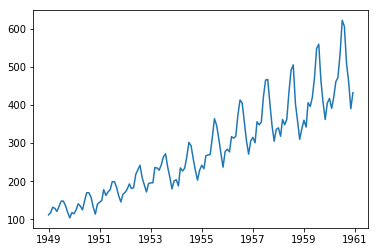

In [4]:
series = pd.read_csv('international-airline-passengers.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
plt.plot(series)
plt.show()

In [5]:
series.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60, dtype: int64

In [6]:
origin_values = series.values.astype('float32')

# normalize the values
scaler = MinMaxScaler(feature_range=(0,1))
origin_values = scaler.fit_transform(origin_values.reshape(-1,1))   # reshape(-1,1) here is important
origin_values[4:10]

array([[ 0.03281853],
       [ 0.05984557],
       [ 0.08494207],
       [ 0.08494207],
       [ 0.06177607],
       [ 0.02895753]], dtype=float32)

In [7]:
train_size = int(len(origin_values)*0.67)
train, test = origin_values[0:train_size,:], origin_values[train_size:len(origin_values),:]
print len(train), len(test)
print train[4:10]

96 48
[[ 0.03281853]
 [ 0.05984557]
 [ 0.08494207]
 [ 0.08494207]
 [ 0.06177607]
 [ 0.02895753]]


In [8]:
# dataX indicates time t-look_back+1, while dataY indicates time t+1
def shift_time(dataset, look_back):
    dataX = []
    dataY = []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back),0])
        dataY.append(dataset[i+look_back,0])
    return np.array(dataX), np.array(dataY)

In [9]:
time_step = 1
look_back = 1
trainX, trainY = shift_time(train, look_back)
testX, testY = shift_time(test, look_back)

print trainX[4:10]
print trainY[4:10]
print trainX.shape

[[ 0.03281853]
 [ 0.05984557]
 [ 0.08494207]
 [ 0.08494207]
 [ 0.06177607]
 [ 0.02895753]]
[ 0.05984557  0.08494207  0.08494207  0.06177607  0.02895753  0.        ]
(95, 1)


In [10]:
# reshape data into [samples, time_step, dimension], so that LSTM can read
## In this case, X, Y should be the same dimension, since Y is the sequence you want to predict from X

trainX = np.reshape(trainX, (trainX.shape[0], time_step, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], time_step, testX.shape[1]))

In [11]:
print trainX[4:10]
print testX[4:10]

[[[ 0.03281853]]

 [[ 0.05984557]]

 [[ 0.08494207]]

 [[ 0.08494207]]

 [[ 0.06177607]]

 [[ 0.02895753]]]
[[[ 0.48455599]]

 [[ 0.61389959]]

 [[ 0.69691122]]

 [[ 0.70077217]]

 [[ 0.57915056]]

 [[ 0.46911195]]]


In [47]:
trainX.shape[1:]

(1, 1)

In [48]:
# LSTM model

model = Sequential()
model.add(LSTM(4, input_shape=trainX.shape[1:]))  # LSTM just want (time_stem, dimension) as input_shape
model.add(Dense(1))  # single output
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2,
         validation_data=(testX, testY))

Train on 95 samples, validate on 47 samples
Epoch 1/100
1s - loss: 0.0328 - val_loss: 0.1836
Epoch 2/100
0s - loss: 0.0150 - val_loss: 0.1219
Epoch 3/100
0s - loss: 0.0123 - val_loss: 0.1048
Epoch 4/100
0s - loss: 0.0115 - val_loss: 0.0894
Epoch 5/100
0s - loss: 0.0107 - val_loss: 0.0869
Epoch 6/100
0s - loss: 0.0100 - val_loss: 0.0771
Epoch 7/100
0s - loss: 0.0091 - val_loss: 0.0699
Epoch 8/100
0s - loss: 0.0083 - val_loss: 0.0627
Epoch 9/100
0s - loss: 0.0074 - val_loss: 0.0569
Epoch 10/100
0s - loss: 0.0066 - val_loss: 0.0438
Epoch 11/100
0s - loss: 0.0059 - val_loss: 0.0374
Epoch 12/100
0s - loss: 0.0051 - val_loss: 0.0308
Epoch 13/100
0s - loss: 0.0045 - val_loss: 0.0296
Epoch 14/100
0s - loss: 0.0039 - val_loss: 0.0224
Epoch 15/100
0s - loss: 0.0035 - val_loss: 0.0197
Epoch 16/100
0s - loss: 0.0031 - val_loss: 0.0159
Epoch 17/100
0s - loss: 0.0028 - val_loss: 0.0137
Epoch 18/100
0s - loss: 0.0025 - val_loss: 0.0120
Epoch 19/100
0s - loss: 0.0024 - val_loss: 0.0116
Epoch 20/100
0s

In [50]:
# make prediction

train_predict = model.predict(trainX)
test_predict = model.predict(testX)

train_RMSE = math.sqrt(mean_squared_error(trainY[:], train_predict[:,0]))
print 'Train RMSE: %.7f' % (train_RMSE)
test_RMSE = math.sqrt(mean_squared_error(testY[:], test_predict[:,0]))
print 'Test RMSE: %.7f' % (test_RMSE)

Train RMSE: 0.0448690
Test RMSE: 0.0961093


In [51]:
print train_predict[4:10]
print origin_values.shape
print train_predict.shape
print test_predict.shape

[[ 0.04352565]
 [ 0.06731328]
 [ 0.08974933]
 [ 0.08974933]
 [ 0.0690277 ]
 [ 0.04016139]]
(144, 1)
(95, 1)
(47, 1)


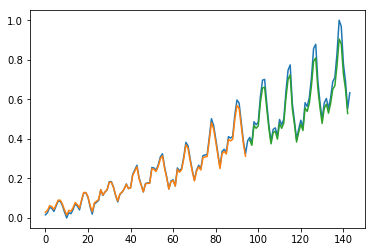

In [52]:
# plot the prediction

train_predict_plot = np.empty_like(origin_values)
train_predict_plot[:, :] = np.nan
train_predict_plot[0:len(train_predict), :] = train_predict

test_predict_plot = np.empty_like(origin_values)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+look_back:len(origin_values)-1, :] = test_predict

plt.plot(origin_values)
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()

In [13]:
# METHOD 2 - WINDOW method
## time t-2, t-1, t to predict time t+1
## Compared with Method 1, you just change look_back value
## and when you have n look_back, your features (trainX, testX) will have n columns

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [19]:
np.random.seed(410)
series = pd.read_csv('international-airline-passengers.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

origin_values = series.values.astype('float32')

# normalize the values
scaler = MinMaxScaler(feature_range=(0,1))
origin_values = scaler.fit_transform(origin_values.reshape(-1,1))   # reshape(-1,1) here is important

train_size = int(len(origin_values)*0.67)
train, test = origin_values[0:train_size,:], origin_values[train_size:len(origin_values),:]

print len(train), len(test)
print train[4:10]
print test[4:10]

96 48
[[ 0.03281853]
 [ 0.05984557]
 [ 0.08494207]
 [ 0.08494207]
 [ 0.06177607]
 [ 0.02895753]]
[[ 0.48455599]
 [ 0.61389959]
 [ 0.69691122]
 [ 0.70077217]
 [ 0.57915056]
 [ 0.46911195]]


In [20]:
# dataX indicates time t-look_back+1, while dataY indicates time t+1
def shift_time(dataset, look_back):
    dataX = []
    dataY = []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back),0])
        dataY.append(dataset[i+look_back,0])
    return np.array(dataX), np.array(dataY)

In [21]:
time_step = 1
look_back = 3
trainX, trainY = shift_time(train, look_back)
testX, testY = shift_time(test, look_back)
print trainX[4:10]
print trainY[4:10]
print trainX.shape

[[ 0.03281853  0.05984557  0.08494207]
 [ 0.05984557  0.08494207  0.08494207]
 [ 0.08494207  0.08494207  0.06177607]
 [ 0.08494207  0.06177607  0.02895753]
 [ 0.06177607  0.02895753  0.        ]
 [ 0.02895753  0.          0.02702703]]
[ 0.08494207  0.06177607  0.02895753  0.          0.02702703  0.02123553]
(93, 3)


In [22]:
# reshape data into [samples, time_step, dimension], so that LSTM can read
## In this case, X, Y should be the same dimension, since Y is the sequence you want to predict from X
trainX = np.reshape(trainX, (trainX.shape[0], time_step, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], time_step, testX.shape[1]))

print trainX[4:10]
print testX[4:10]

[[[ 0.03281853  0.05984557  0.08494207]]

 [[ 0.05984557  0.08494207  0.08494207]]

 [[ 0.08494207  0.08494207  0.06177607]]

 [[ 0.08494207  0.06177607  0.02895753]]

 [[ 0.06177607  0.02895753  0.        ]]

 [[ 0.02895753  0.          0.02702703]]]
[[[ 0.48455599  0.61389959  0.69691122]]

 [[ 0.61389959  0.69691122  0.70077217]]

 [[ 0.69691122  0.70077217  0.57915056]]

 [[ 0.70077217  0.57915056  0.46911195]]

 [[ 0.57915056  0.46911195  0.38803086]]

 [[ 0.46911195  0.38803086  0.44787642]]]


In [23]:
# LSTM model

model = Sequential()
model.add(LSTM(4, input_shape=trainX.shape[1:]))  # LSTM just want (time_stem, dimension) as input_shape
model.add(Dense(1))  # single output
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2,
         validation_data=(testX, testY))

Train on 93 samples, validate on 45 samples
Epoch 1/100
1s - loss: 0.0235 - val_loss: 0.1215
Epoch 2/100
0s - loss: 0.0097 - val_loss: 0.0744
Epoch 3/100
0s - loss: 0.0082 - val_loss: 0.0641
Epoch 4/100
0s - loss: 0.0074 - val_loss: 0.0518
Epoch 5/100
0s - loss: 0.0066 - val_loss: 0.0435
Epoch 6/100
0s - loss: 0.0059 - val_loss: 0.0398
Epoch 7/100
0s - loss: 0.0054 - val_loss: 0.0338
Epoch 8/100
0s - loss: 0.0051 - val_loss: 0.0284
Epoch 9/100
0s - loss: 0.0048 - val_loss: 0.0270
Epoch 10/100
0s - loss: 0.0045 - val_loss: 0.0245
Epoch 11/100
0s - loss: 0.0044 - val_loss: 0.0248
Epoch 12/100
0s - loss: 0.0043 - val_loss: 0.0235
Epoch 13/100
0s - loss: 0.0042 - val_loss: 0.0225
Epoch 14/100
0s - loss: 0.0041 - val_loss: 0.0201
Epoch 15/100
0s - loss: 0.0040 - val_loss: 0.0213
Epoch 16/100
0s - loss: 0.0040 - val_loss: 0.0201
Epoch 17/100
0s - loss: 0.0039 - val_loss: 0.0196
Epoch 18/100
0s - loss: 0.0038 - val_loss: 0.0190
Epoch 19/100
0s - loss: 0.0039 - val_loss: 0.0183
Epoch 20/100
0s

In [29]:
# make prediction

train_predict = model.predict(trainX)
test_predict = model.predict(testX)

train_RMSE = math.sqrt(mean_squared_error(trainY, train_predict[:,0]))
print 'Train RMSE: %.7f' % (train_RMSE)
test_RMSE = math.sqrt(mean_squared_error(testY, test_predict[:,0]))
print 'Test RMSE: %.7f' % (test_RMSE)

Train RMSE: 0.0459457
Test RMSE: 0.1132370


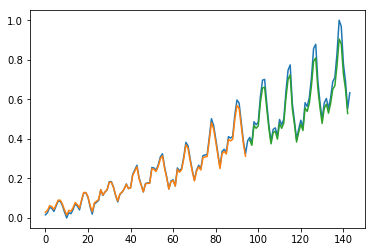

In [53]:
# plot the prediction

train_predict_plot = np.empty_like(origin_values)
train_predict_plot[:, :] = np.nan
train_predict_plot[0:len(train_predict), :] = train_predict

test_predict_plot = np.empty_like(origin_values)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+look_back*2-1:len(origin_values)-1, :] = test_predict

plt.plot(origin_values)
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()

In [14]:
# METHOD 3 - exchange time_step and dimension in reshaped data

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [15]:
np.random.seed(410)
series = pd.read_csv('international-airline-passengers.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

origin_values = series.values.astype('float32')

# normalize the values
scaler = MinMaxScaler(feature_range=(0,1))
origin_values = scaler.fit_transform(origin_values.reshape(-1,1))   # reshape(-1,1) here is important

train_size = int(len(origin_values)*0.67)
train, test = origin_values[0:train_size,:], origin_values[train_size:len(origin_values),:]

print len(train), len(test)
print train[4:10]
print test[4:10]

96 48
[[ 0.03281853]
 [ 0.05984557]
 [ 0.08494207]
 [ 0.08494207]
 [ 0.06177607]
 [ 0.02895753]]
[[ 0.48455599]
 [ 0.61389959]
 [ 0.69691122]
 [ 0.70077217]
 [ 0.57915056]
 [ 0.46911195]]


In [16]:
# dataX indicates time t-look_back+1, while dataY indicates time t+1
def shift_time(dataset, look_back):
    dataX = []
    dataY = []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back),0])
        dataY.append(dataset[i+look_back,0])
    return np.array(dataX), np.array(dataY)

In [17]:
time_step = 1
look_back = 1
trainX, trainY = shift_time(train, look_back)
testX, testY = shift_time(test, look_back)

print trainX[4:10]
print trainY[4:10]
print trainX.shape

[[ 0.03281853]
 [ 0.05984557]
 [ 0.08494207]
 [ 0.08494207]
 [ 0.06177607]
 [ 0.02895753]]
[ 0.05984557  0.08494207  0.08494207  0.06177607  0.02895753  0.        ]
(95, 1)


In [19]:
# reshape data into [samples, dimension, time_step], so that LSTM can read
## Compare with Method 1, Method 2, here's the difference: just change the position of dimension and time_step

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], time_step))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], time_step))

print trainX[4:10]
print testX[4:10]

[[[ 0.03281853]]

 [[ 0.05984557]]

 [[ 0.08494207]]

 [[ 0.08494207]]

 [[ 0.06177607]]

 [[ 0.02895753]]]
[[[ 0.48455599]]

 [[ 0.61389959]]

 [[ 0.69691122]]

 [[ 0.70077217]]

 [[ 0.57915056]]

 [[ 0.46911195]]]


In [20]:
# LSTM model

model = Sequential()
model.add(LSTM(4, input_shape=trainX.shape[1:]))  # LSTM just want (time_stem, dimension) as input_shape
model.add(Dense(1))  # single output
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2,
         validation_data=(testX, testY))

Train on 95 samples, validate on 47 samples
Epoch 1/100
1s - loss: 0.0328 - val_loss: 0.1836
Epoch 2/100
0s - loss: 0.0150 - val_loss: 0.1219
Epoch 3/100
0s - loss: 0.0123 - val_loss: 0.1048
Epoch 4/100
0s - loss: 0.0115 - val_loss: 0.0894
Epoch 5/100
0s - loss: 0.0107 - val_loss: 0.0869
Epoch 6/100
0s - loss: 0.0100 - val_loss: 0.0771
Epoch 7/100
0s - loss: 0.0091 - val_loss: 0.0699
Epoch 8/100
0s - loss: 0.0083 - val_loss: 0.0627
Epoch 9/100
0s - loss: 0.0074 - val_loss: 0.0569
Epoch 10/100
0s - loss: 0.0066 - val_loss: 0.0438
Epoch 11/100
0s - loss: 0.0059 - val_loss: 0.0374
Epoch 12/100
0s - loss: 0.0051 - val_loss: 0.0309
Epoch 13/100
0s - loss: 0.0045 - val_loss: 0.0297
Epoch 14/100
0s - loss: 0.0039 - val_loss: 0.0224
Epoch 15/100
0s - loss: 0.0035 - val_loss: 0.0197
Epoch 16/100
0s - loss: 0.0031 - val_loss: 0.0159
Epoch 17/100
0s - loss: 0.0028 - val_loss: 0.0137
Epoch 18/100
0s - loss: 0.0025 - val_loss: 0.0120
Epoch 19/100
0s - loss: 0.0024 - val_loss: 0.0116
Epoch 20/100
0s

In [21]:
# make prediction

train_predict = model.predict(trainX)
test_predict = model.predict(testX)

train_RMSE = math.sqrt(mean_squared_error(trainY[:], train_predict[:,0]))
print 'Train RMSE: %.7f' % (train_RMSE)
test_RMSE = math.sqrt(mean_squared_error(testY[:], test_predict[:,0]))
print 'Test RMSE: %.7f' % (test_RMSE)
print

print train_predict[4:10]
print origin_values.shape
print train_predict.shape
print test_predict.shape

Train RMSE: 0.0448691
Test RMSE: 0.0961101

[[ 0.04352463]
 [ 0.0673124 ]
 [ 0.08974855]
 [ 0.08974855]
 [ 0.06902682]
 [ 0.04016035]]
(144, 1)
(95, 1)
(47, 1)


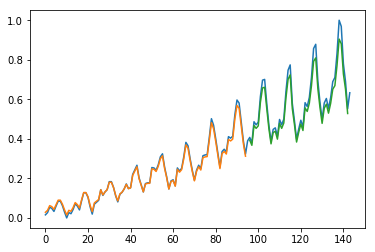

In [24]:
# plot the prediction

train_predict_plot = np.empty_like(origin_values)
train_predict_plot[:, :] = np.nan
train_predict_plot[0:len(train_predict), :] = train_predict

test_predict_plot = np.empty_like(origin_values)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+look_back:len(origin_values)-1, :] = test_predict

plt.plot(origin_values)
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()

In [25]:
# METHOD 4 - LSTM with memory between batches

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [26]:
np.random.seed(410)
series = pd.read_csv('international-airline-passengers.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

origin_values = series.values.astype('float32')

# normalize the values
scaler = MinMaxScaler(feature_range=(0,1))
origin_values = scaler.fit_transform(origin_values.reshape(-1,1))   # reshape(-1,1) here is important

train_size = int(len(origin_values)*0.67)
train, test = origin_values[0:train_size,:], origin_values[train_size:len(origin_values),:]

print len(train), len(test)
print train[4:10]
print test[4:10]

96 48
[[ 0.03281853]
 [ 0.05984557]
 [ 0.08494207]
 [ 0.08494207]
 [ 0.06177607]
 [ 0.02895753]]
[[ 0.48455599]
 [ 0.61389959]
 [ 0.69691122]
 [ 0.70077217]
 [ 0.57915056]
 [ 0.46911195]]


In [27]:
# dataX indicates time t-look_back+1, while dataY indicates time t+1
def shift_time(dataset, look_back):
    dataX = []
    dataY = []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back),0])
        dataY.append(dataset[i+look_back,0])
    return np.array(dataX), np.array(dataY)

In [28]:
time_step = 1
look_back = 3
trainX, trainY = shift_time(train, look_back)
testX, testY = shift_time(test, look_back)

print trainX[4:10]
print trainY[4:10]
print trainX.shape

[[ 0.03281853  0.05984557  0.08494207]
 [ 0.05984557  0.08494207  0.08494207]
 [ 0.08494207  0.08494207  0.06177607]
 [ 0.08494207  0.06177607  0.02895753]
 [ 0.06177607  0.02895753  0.        ]
 [ 0.02895753  0.          0.02702703]]
[ 0.08494207  0.06177607  0.02895753  0.          0.02702703  0.02123553]
(93, 3)


In [29]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], time_step))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], time_step))

print trainX[4:10]
print testX[4:10]

[[[ 0.03281853]
  [ 0.05984557]
  [ 0.08494207]]

 [[ 0.05984557]
  [ 0.08494207]
  [ 0.08494207]]

 [[ 0.08494207]
  [ 0.08494207]
  [ 0.06177607]]

 [[ 0.08494207]
  [ 0.06177607]
  [ 0.02895753]]

 [[ 0.06177607]
  [ 0.02895753]
  [ 0.        ]]

 [[ 0.02895753]
  [ 0.        ]
  [ 0.02702703]]]
[[[ 0.48455599]
  [ 0.61389959]
  [ 0.69691122]]

 [[ 0.61389959]
  [ 0.69691122]
  [ 0.70077217]]

 [[ 0.69691122]
  [ 0.70077217]
  [ 0.57915056]]

 [[ 0.70077217]
  [ 0.57915056]
  [ 0.46911195]]

 [[ 0.57915056]
  [ 0.46911195]
  [ 0.38803086]]

 [[ 0.46911195]
  [ 0.38803086]
  [ 0.44787642]]]


In [30]:
# Here comes details that makes method 4 different from the above methods

## first of all, in your LSTM model, set stateful as True
## Also need to hard code batch_input_shape:
### number of samples in a batch
### number of time steps in a sample
### number of features in a time step
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, time_step), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [31]:
## secondly, you need to create a loop of epoches and fit the model + reset state in each epoch
### This is because training data cannot be shuffled when fitting the model
### and you need to explicit reset the network state after each epoch, after training prediction

for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

Epoch 1/1
2s - loss: 0.0043
Epoch 1/1
1s - loss: 0.0096
Epoch 1/1
1s - loss: 0.0073
Epoch 1/1
0s - loss: 0.0059
Epoch 1/1
0s - loss: 0.0051
Epoch 1/1
1s - loss: 0.0046
Epoch 1/1
1s - loss: 0.0044
Epoch 1/1
1s - loss: 0.0042
Epoch 1/1
1s - loss: 0.0041
Epoch 1/1
0s - loss: 0.0041
Epoch 1/1
0s - loss: 0.0040
Epoch 1/1
1s - loss: 0.0040
Epoch 1/1
0s - loss: 0.0039
Epoch 1/1
0s - loss: 0.0039
Epoch 1/1
1s - loss: 0.0039
Epoch 1/1
1s - loss: 0.0039
Epoch 1/1
0s - loss: 0.0038
Epoch 1/1
0s - loss: 0.0038
Epoch 1/1
0s - loss: 0.0038
Epoch 1/1
0s - loss: 0.0038
Epoch 1/1
0s - loss: 0.0037
Epoch 1/1
1s - loss: 0.0037
Epoch 1/1
0s - loss: 0.0037
Epoch 1/1
0s - loss: 0.0037
Epoch 1/1
0s - loss: 0.0036
Epoch 1/1
1s - loss: 0.0036
Epoch 1/1
0s - loss: 0.0036
Epoch 1/1
0s - loss: 0.0036
Epoch 1/1
0s - loss: 0.0036
Epoch 1/1
1s - loss: 0.0035
Epoch 1/1
0s - loss: 0.0035
Epoch 1/1
0s - loss: 0.0035
Epoch 1/1
1s - loss: 0.0035
Epoch 1/1
1s - loss: 0.0035
Epoch 1/1
0s - loss: 0.0034
Epoch 1/1
1s - loss:

In [33]:
# make predictions

## here, you have to specify the same batch_size used above
train_predict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
test_predict = model.predict(testX, batch_size=batch_size)

train_RMSE = math.sqrt(mean_squared_error(trainY[:], train_predict[:,0]))
print 'Train RMSE: %.7f' % (train_RMSE)
test_RMSE = math.sqrt(mean_squared_error(testY[:], test_predict[:,0]))
print 'Test RMSE: %.7f' % (test_RMSE)
print

print train_predict[4:10]
print origin_values.shape
print train_predict.shape
print test_predict.shape

Train RMSE: 0.0440787
Test RMSE: 0.0971128

[[ 0.08172657]
 [ 0.08843055]
 [ 0.07361747]
 [ 0.04675714]
 [ 0.01867417]
 [ 0.02978996]]
(144, 1)
(93, 1)
(45, 1)


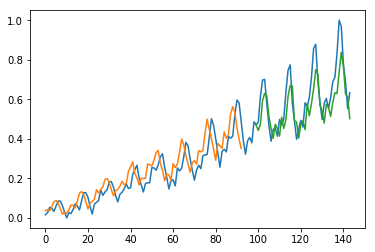

In [44]:
train_predict_plot = np.empty_like(origin_values)
train_predict_plot[:, :] = np.nan
train_predict_plot[0:len(train_predict), :] = train_predict

test_predict_plot = np.empty_like(origin_values)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+look_back*2:len(origin_values), :] = test_predict

plt.plot(origin_values)
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()

In [45]:
# Method 5 - Stacked LSTMs with Memory Between Batches
## You just stack multiple LSTM models together

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [57]:
np.random.seed(410)
series = pd.read_csv('international-airline-passengers.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

origin_values = series.values.astype('float32')

# normalize the values
scaler = MinMaxScaler(feature_range=(0,1))
origin_values = scaler.fit_transform(origin_values.reshape(-1,1))   # reshape(-1,1) here is important

train_size = int(len(origin_values)*0.67)
train, test = origin_values[0:train_size,:], origin_values[train_size:len(origin_values),:]

print len(train), len(test)
print train[4:10]
print test[4:10]

96 48
[[ 0.03281853]
 [ 0.05984557]
 [ 0.08494207]
 [ 0.08494207]
 [ 0.06177607]
 [ 0.02895753]]
[[ 0.48455599]
 [ 0.61389959]
 [ 0.69691122]
 [ 0.70077217]
 [ 0.57915056]
 [ 0.46911195]]


In [58]:
# dataX indicates time t-look_back+1, while dataY indicates time t+1
def shift_time(dataset, look_back):
    dataX = []
    dataY = []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back),0])
        dataY.append(dataset[i+look_back,0])
    return np.array(dataX), np.array(dataY)

In [64]:
time_step = 1
look_back = 3
trainX, trainY = shift_time(train, look_back)
testX, testY = shift_time(test, look_back)

print trainX[4:10]
print trainY[4:10]
print trainX.shape

[[ 0.03281853  0.05984557  0.08494207]
 [ 0.05984557  0.08494207  0.08494207]
 [ 0.08494207  0.08494207  0.06177607]
 [ 0.08494207  0.06177607  0.02895753]
 [ 0.06177607  0.02895753  0.        ]
 [ 0.02895753  0.          0.02702703]]
[ 0.08494207  0.06177607  0.02895753  0.          0.02702703  0.02123553]
(93, 3)


In [65]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], time_step))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], time_step))

print trainX[4:10]
print testX[4:10]

[[[ 0.03281853]
  [ 0.05984557]
  [ 0.08494207]]

 [[ 0.05984557]
  [ 0.08494207]
  [ 0.08494207]]

 [[ 0.08494207]
  [ 0.08494207]
  [ 0.06177607]]

 [[ 0.08494207]
  [ 0.06177607]
  [ 0.02895753]]

 [[ 0.06177607]
  [ 0.02895753]
  [ 0.        ]]

 [[ 0.02895753]
  [ 0.        ]
  [ 0.02702703]]]
[[[ 0.48455599]
  [ 0.61389959]
  [ 0.69691122]]

 [[ 0.61389959]
  [ 0.69691122]
  [ 0.70077217]]

 [[ 0.69691122]
  [ 0.70077217]
  [ 0.57915056]]

 [[ 0.70077217]
  [ 0.57915056]
  [ 0.46911195]]

 [[ 0.57915056]
  [ 0.46911195]
  [ 0.38803086]]

 [[ 0.46911195]
  [ 0.38803086]
  [ 0.44787642]]]


In [66]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [67]:
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

Epoch 1/1
4s - loss: 0.0047
Epoch 1/1
1s - loss: 0.0132
Epoch 1/1
1s - loss: 0.0088
Epoch 1/1
1s - loss: 0.0070
Epoch 1/1
1s - loss: 0.0061
Epoch 1/1
1s - loss: 0.0058
Epoch 1/1
1s - loss: 0.0057
Epoch 1/1
1s - loss: 0.0056
Epoch 1/1
1s - loss: 0.0055
Epoch 1/1
1s - loss: 0.0055
Epoch 1/1
1s - loss: 0.0055
Epoch 1/1
1s - loss: 0.0055
Epoch 1/1
1s - loss: 0.0054
Epoch 1/1
1s - loss: 0.0054
Epoch 1/1
1s - loss: 0.0054
Epoch 1/1
1s - loss: 0.0054
Epoch 1/1
1s - loss: 0.0054
Epoch 1/1
1s - loss: 0.0054
Epoch 1/1
1s - loss: 0.0053
Epoch 1/1
1s - loss: 0.0053
Epoch 1/1
1s - loss: 0.0053
Epoch 1/1
1s - loss: 0.0053
Epoch 1/1
1s - loss: 0.0052
Epoch 1/1
1s - loss: 0.0052
Epoch 1/1
1s - loss: 0.0052
Epoch 1/1
1s - loss: 0.0051
Epoch 1/1
1s - loss: 0.0051
Epoch 1/1
1s - loss: 0.0050
Epoch 1/1
1s - loss: 0.0050
Epoch 1/1
1s - loss: 0.0049
Epoch 1/1
1s - loss: 0.0048
Epoch 1/1
1s - loss: 0.0047
Epoch 1/1
1s - loss: 0.0047
Epoch 1/1
1s - loss: 0.0046
Epoch 1/1
1s - loss: 0.0045
Epoch 1/1
1s - loss:

In [68]:
# make predictions

## here, you have to specify the same batch_size used above
train_predict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
test_predict = model.predict(testX, batch_size=batch_size)

train_RMSE = math.sqrt(mean_squared_error(trainY[:], train_predict[:,0]))
print 'Train RMSE: %.7f' % (train_RMSE)
test_RMSE = math.sqrt(mean_squared_error(testY[:], test_predict[:,0]))
print 'Test RMSE: %.7f' % (test_RMSE)
print

print train_predict[4:10]
print origin_values.shape
print train_predict.shape
print test_predict.shape

Train RMSE: 0.0400681
Test RMSE: 0.1387102

[[ 0.08066928]
 [ 0.0845684 ]
 [ 0.06806657]
 [ 0.04468185]
 [ 0.02371259]
 [ 0.03402945]]
(144, 1)
(93, 1)
(45, 1)


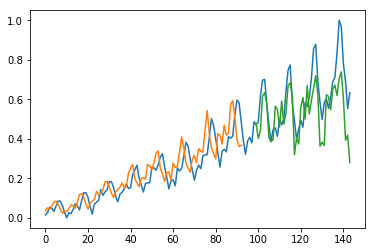

In [69]:
train_predict_plot = np.empty_like(origin_values)
train_predict_plot[:, :] = np.nan
train_predict_plot[0:len(train_predict), :] = train_predict

test_predict_plot = np.empty_like(origin_values)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+look_back*2:len(origin_values), :] = test_predict

plt.plot(origin_values)
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()